# Week 9 




<div style="color:blue;font-style:italic">28.02.2022 - 04.03.2022 </div>


<div style="background-color:rgba(256, 76, 76,0.4)",height="200">

<br>

<H4>Abstract</H4>

<br>

</div>

---

While Bayesian statistics provide deep insights into the parameter space of a certain model, a major drawback are the long execution times. When the same bayesian model is fit to multiple datasets, parallelization of the sampling step might help overcome this drawback. Graphical Processing Units offer an oppertunity to parallelize a large amount of tasks, making attempts to sample a set of models simultanously on a GPU an interesting experiment. The developers of pymc recently implemented a jax backend making it possible to run Nuts on the GPU.

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Introduction</H4>
<br>
</div>

---


After developing on methods for feature extraction from data-dependent-acquisition datasets, the next step in a prototype pipeline for a bayesian precursor feature analysis is the data transfer to the model. Bayesian statistics provide deep insights in the
possible parameters of a model, however this comes with rather long sampling runtimes. But since the evaluation of two features can be performed independently, parallelization might help overcome this drawback. Nevertheless we need to keep in mind, that 
the evaluation of a single feature necessarily gives rise to multiple threads corresponding to the number of chains used for convergence control <cite data-cite="GelmanRubin92"></cite>. It is obvious that running multiple feature evaluations parallely - each running e.g. 4 chains parallely - quickly pushes the typical workstation CPU to it's limits. However graphical processing units (GPU) might be of help here, since they employ a significant higher number of processing cores (e.g.The here used Geforce GTX 1080Ti employing 3584 CUDA cores <cite data-cite="NvidiaGTX1080Ti"></cite>).
Fitting many models at once on a GPU might speed up the sampling process signifincantly.







---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Methods and Material</H4>
<br>
</div>

---


The probabilistic models are written with the probabilistic programming library PyMC <cite data-cite="pymc3"></cite>. The PyMC developers recently reported a sampling speed up by employing the GPU with pre-release PyMC v4 <cite data-cite="pymcGPU"></cite>. 
PyMC v4 comes with a jax backend allowing for sampling bayesian models with numpyro's No-U-Turn sampler (NUTS) implementation on the GPU <cite data-cite="jax,numpyro"></cite> .

Since parallel sampling of many isntances of the same model on the GPU currently seemed not to be straightforward, a artificial parallelization was accomplished by building a PyMC model, that is spanning n submodels. Each submodel is an instance of the model of interest and is independent of each other submodel. The input data is shaped accordingly. 

As an minimal model example the inference of the mean of a normal distribution was employed (<b>Fig.1</b>):

```python3
with pm.Model() as model:
    data = pm.Data("data", obs_data[0])
    mus = pm.Normal("mus",0,20,shape=d2)
    normals = [pm.Normal(f"obs_{i}",mu = mus[i],sigma=1,\
    observed=data.get_value()[i]) for i in range(d2)]
```
To assay the runtime behaviour over time a total of 640 datasets were created with 10 and 20 datapoints each. These datasets were passed to the artificial modelset with increasing degree of parallelization. The tested numbers of submodels were 1,10,20,40,80,160,320 and 640, i.e. in the first case all datasets were regarded sequentially and in the last case parallely. For both CPU and GPU execution the runtimes were recorded. 

Python scripts for CPU and GPU samping can be downloaded ([CPU](data/pymcCPUtest.py) and [GPU](data/pymcGPUtest.py)).

Due to crashing CPU execution in PyMC v4, CPU python program was executed with PyMC v3.

---

<div style="background-color:white">

<img src="data/modelGraphviz.svg" >

</div>
<figcaption style="font-weight:bold;font-size:small">
Fig 1: Visualization of artificial Model spanning 10 submodels each receiving an independent dataset of normally distributed data of unknown mean. Visualization was created with python-graphviz <cite data-cite="graphviz"></cite>.
</figcaption>

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Results</H4>
<br>
</div>

---
Since the GPU sampling run with datasets containing 20 datapoints failed at high degrees of paralellization and needs yet to be repeated, three experiments were compared: CPU sampling of datasets with D3 = 10 (``` CPUD310```) and D3 = 20 (``` CPUD320```), with D3 being the number of datapoints , GPU sampling (chains sequential) with D3 = 10 and vectorized GPU sampling (chains parallelized) with D3 = 10 (both in ```GPUD10```). The code below loads the csv files in which the measured runtimes were stored. 

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")

# Loading runs on datasets with 10 datapoints for every model fit.
CPUD310 = pd.read_csv("data/dataCPUD310.csv",index_col=0)
GPUD310 = pd.read_csv("data/dataGPUD310.csv",index_col=0)

# Loading runs on datasets with 20 datapoints for every model fit. (GPU broke here)
CPUD320 = pd.read_csv("data/dataCPUD320.csv",index_col=0)

# Number of submodels is stored in D2. (same for each experiment)
submodel_n = GPUD310.D2

<b>Fig.2 A</b> shows the change of the execution time (fitting all 640 datasets) depending on number of submodels inside the PyMC model. Since the drop from the complete sequential execution is quite large, <b>Fig.2 B</b> cuts off this case to make the differences between the more parallelized cases visible. In all experiments the runtime first benefits from parallelization, comes to a minimum and then increases againg with high numbers of submodels.

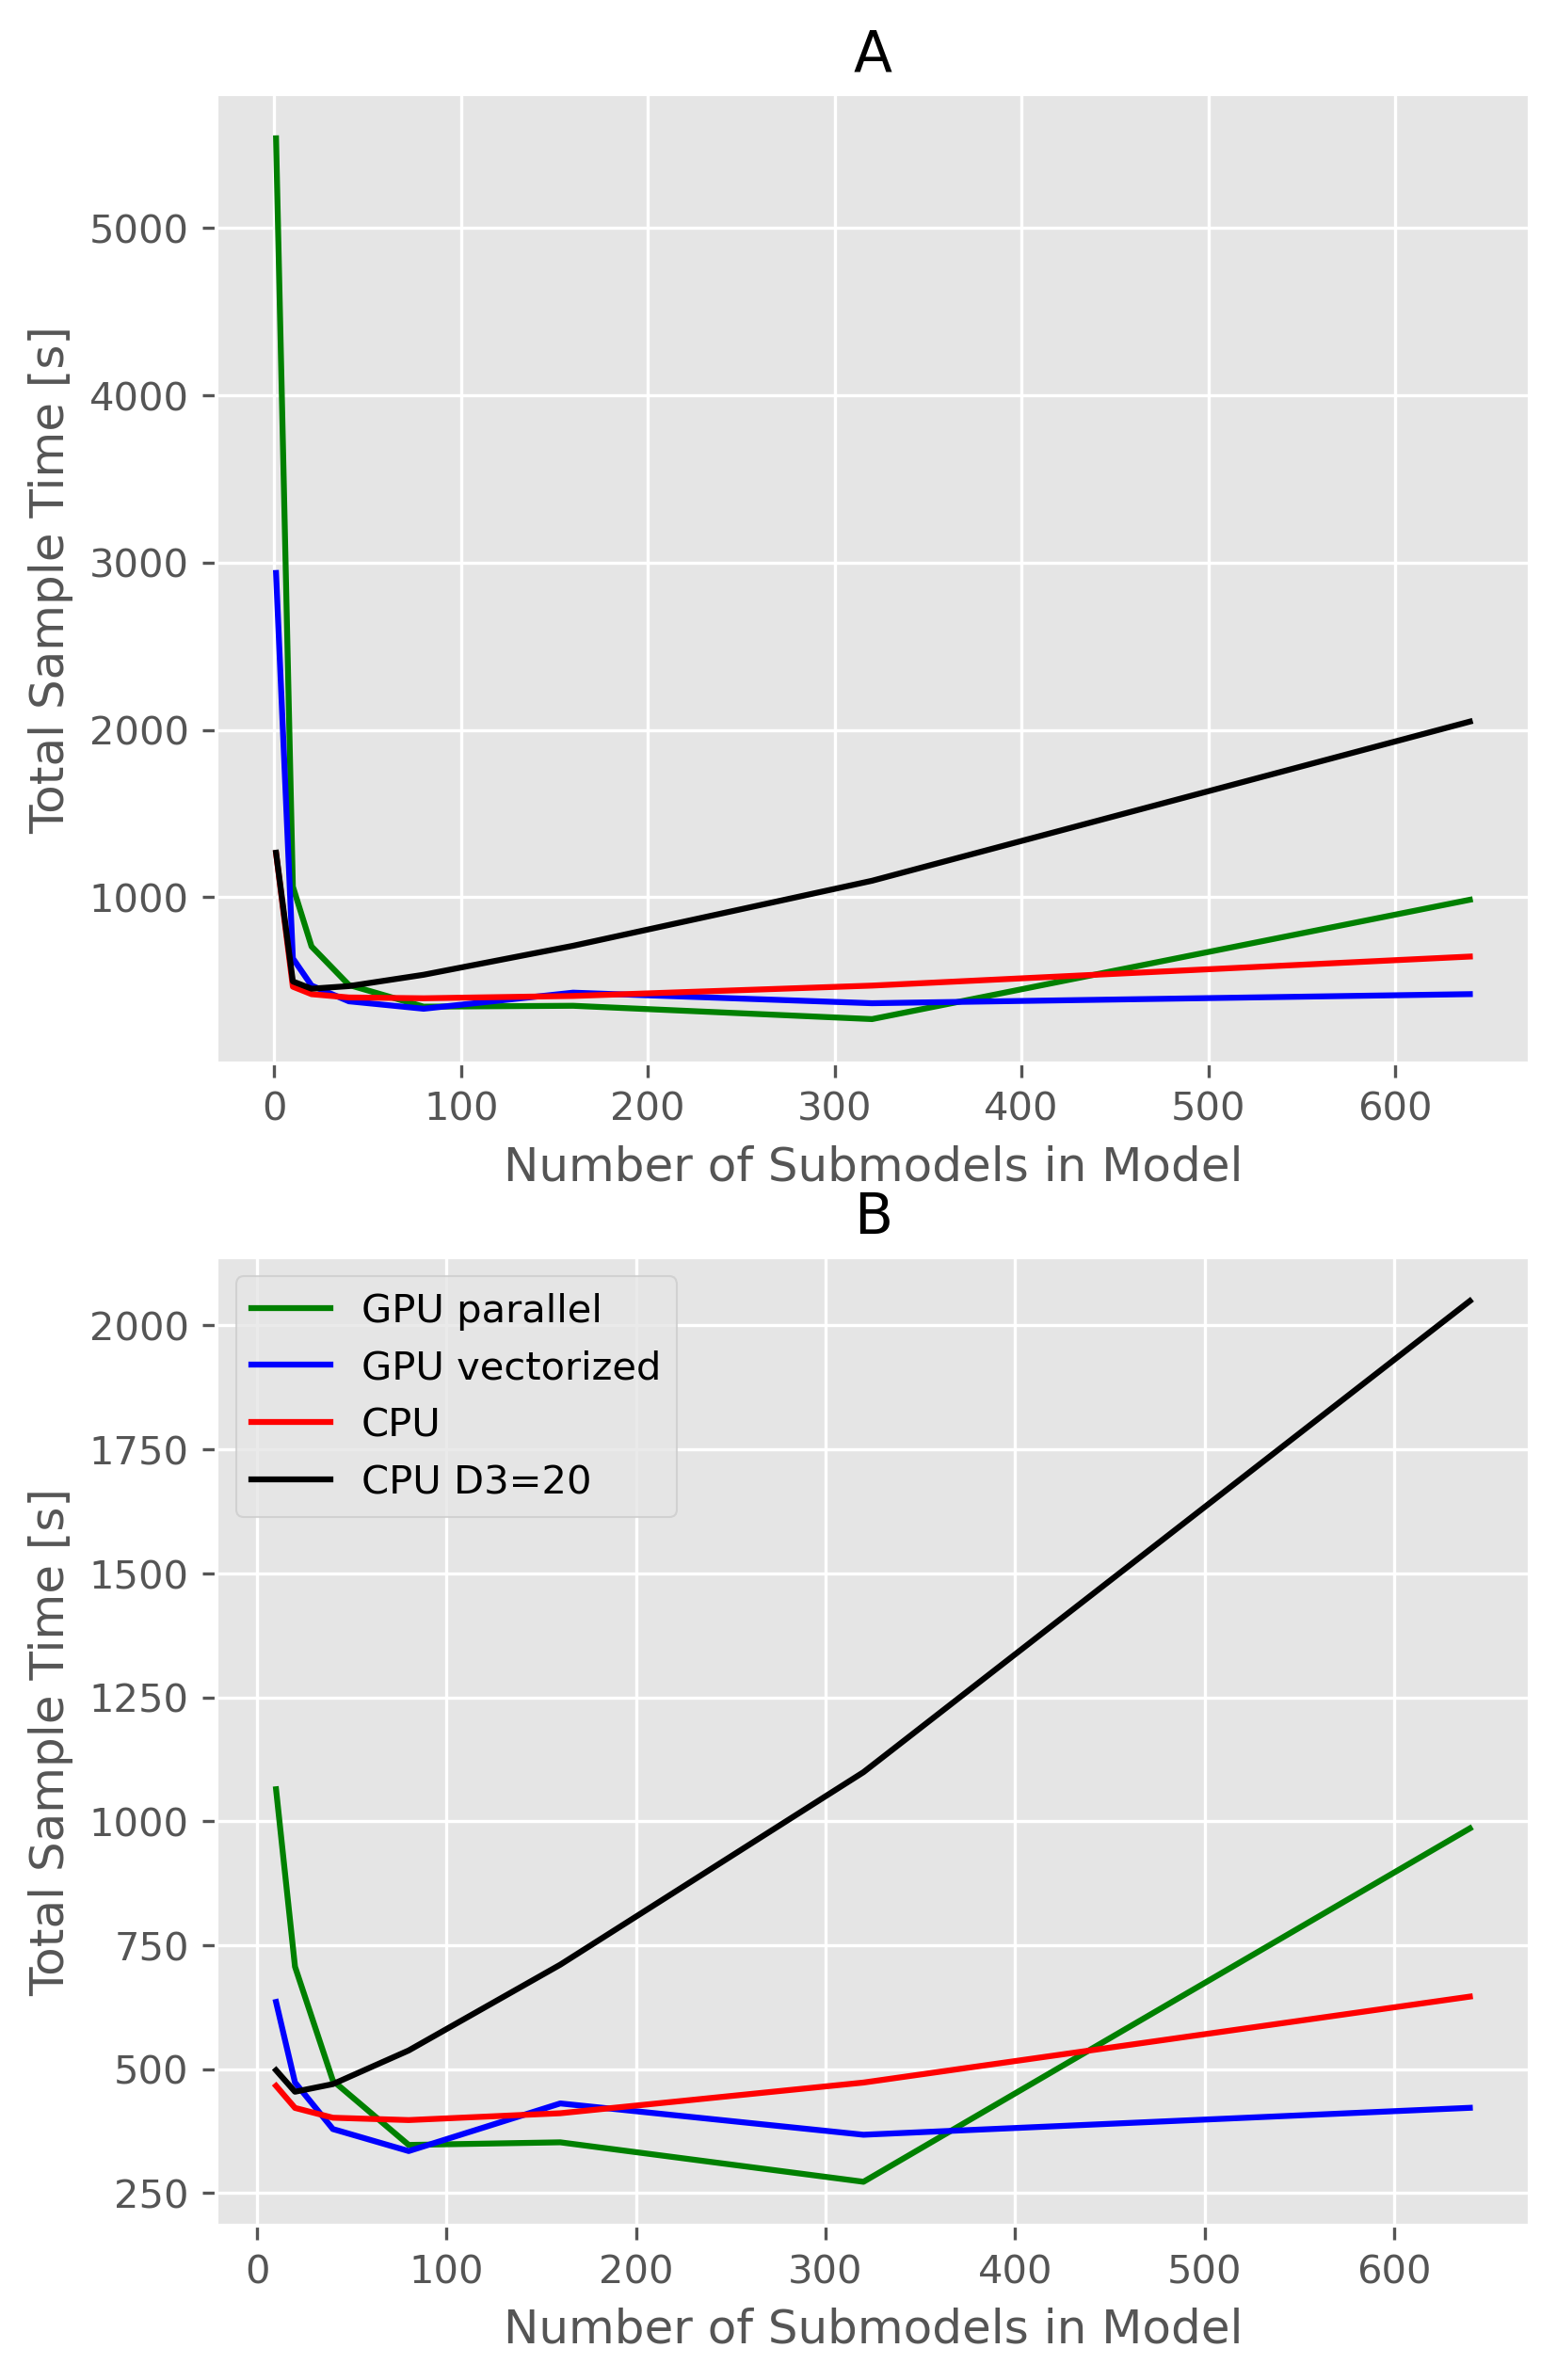

In [31]:
# Figure 2
Fig2, (ax2a,ax2b) = plt.subplots(2,1)
Fig2.set_figheight(10)
Fig2.set_dpi(300)
# plot measured times vs submodel count
ax2a.plot(submodel_n,GPUD310.GPU_times,label="GPU parallel",color="green")
ax2a.plot(submodel_n,GPUD310.GPUv_times,label="GPU vectorized",color="blue")
ax2a.plot(submodel_n,CPUD310.CPU_times,label="CPU",color="red")
ax2a.plot(submodel_n,CPUD320.CPU_times,label="CPU D3=20",color="black")
ax2a.set_title("A")
ax2a.set_xlabel("Number of Submodels in Model")
ax2a.set_ylabel("Total Sample Time [s]")

# ignore measured runtime for submodel count = 1
ax2b.plot(submodel_n[1:],GPUD310.GPU_times[1:],label="GPU parallel",color="green")
ax2b.plot(submodel_n[1:],GPUD310.GPUv_times[1:],label="GPU vectorized",color="blue")
ax2b.plot(submodel_n[1:],CPUD310.CPU_times[1:],label="CPU",color="red")
ax2b.plot(submodel_n[1:],CPUD320.CPU_times[1:], label="CPU D3=20",color="black")


ax2b.legend()
ax2b.set_title("B")

ax2b.set_xlabel("Number of Submodels in Model")
ax2b.set_ylabel("Total Sample Time [s]")

plt.show()


To visualize the speedup <b>Fig.3</b> compares the runtime relative to the CPU execution time of the n_submodels = 1 case. Note, that all runtimes are depicted as times speedup compared to the CPU case with n_submodels = 1 and D3 = 10.

In [32]:
# Calculate speedups

time_CPU_sequential = CPUD310.CPU_times[0]

CPUD310["CPUspeedup"]       = np.round(time_CPU_sequential/CPUD310.CPU_times,1)
GPUD310["GPUspeedup"]       = np.round(time_CPU_sequential/GPUD310.GPU_times,1)
GPUD310["GPUvspeedup"]      = np.round(time_CPU_sequential/GPUD310.GPUv_times,1)
CPUD320["CPUspeedup"]       = np.round(time_CPU_sequential/CPUD320.CPU_times,1)



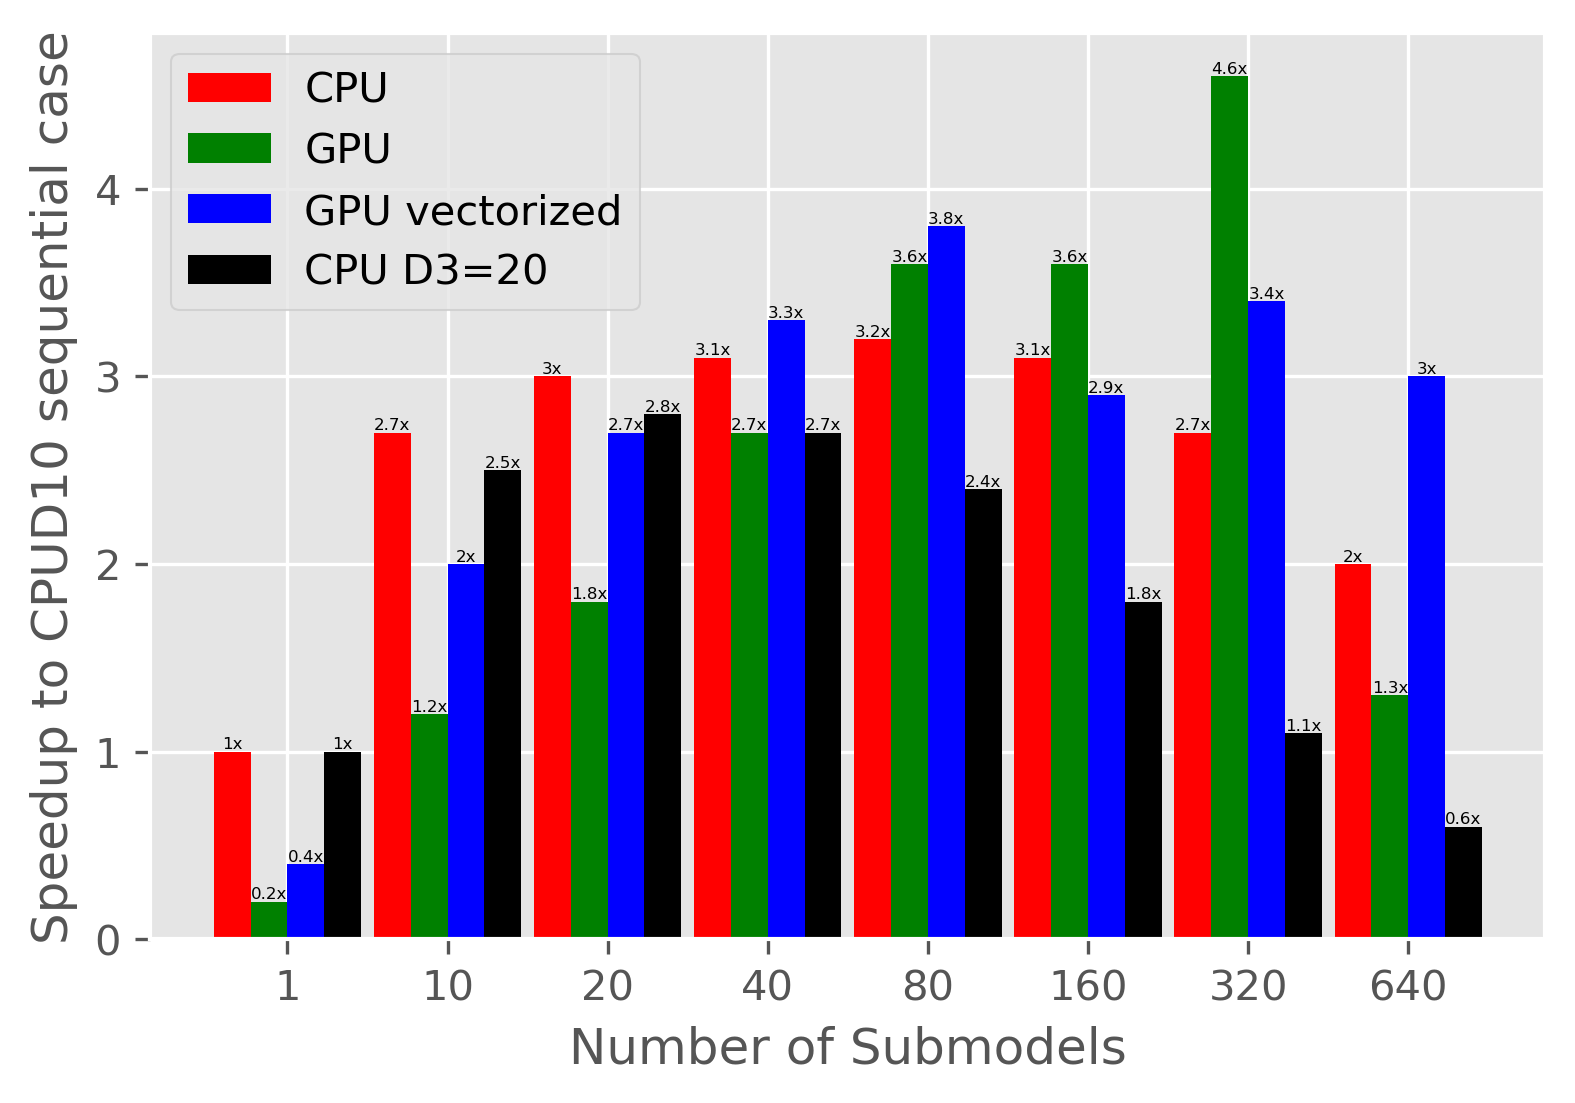

In [33]:
x_positions = np.arange(1,len(CPUD310.CPU_times)+1)
x_labels = submodel_n

width = 0.23

Fig3, ax3 = plt.subplots()
Fig3.set_dpi(300)
r1 = ax3.bar(x_positions-width*1.5,CPUD310.CPUspeedup,width,label="CPU",color="red")
r2 = ax3.bar(x_positions-width*0.5,GPUD310.GPUspeedup,width,label="GPU",color="green")
r3 = ax3.bar(x_positions+width*0.5,GPUD310.GPUvspeedup,width,label="GPU vectorized",color="blue")
r4 = ax3.bar(x_positions+width*1.5,CPUD320.CPUspeedup,width,label="CPU D3=20",color="black")

ax3.set_xticks(x_positions,labels=x_labels)
ax3.legend()

ax3.bar_label(r1,fmt="%gx",size=4)
ax3.bar_label(r2,fmt="%gx",size=4)
ax3.bar_label(r3,fmt="%gx",size=4)
ax3.bar_label(r4,fmt="%gx",size=4)

ax3.set_xlabel("Number of Submodels")
ax3.set_ylabel("Speedup to CPUD10 sequential case")

plt.show()

<b>Fig.3</b> shows that parallelization is beneficial for fitting many datasets to the same probabilistic model. The maximum speedup was accomplished with the GPU (4.6x at n_submodels = 320). However, also the CPU sampling benefited from parallelization, with speedups up to 3.2x. This shows, that even without a GPU faster sampling times can be acquired by artificially largen the model to fit a set of submodels simultanously. 

<b>Fig.5</b> shows model build times. Interestingly, the GPU case here is much faster than the corresponding CPU case. The only difference here however is the PyMC version, since the models are not built on the GPU. 

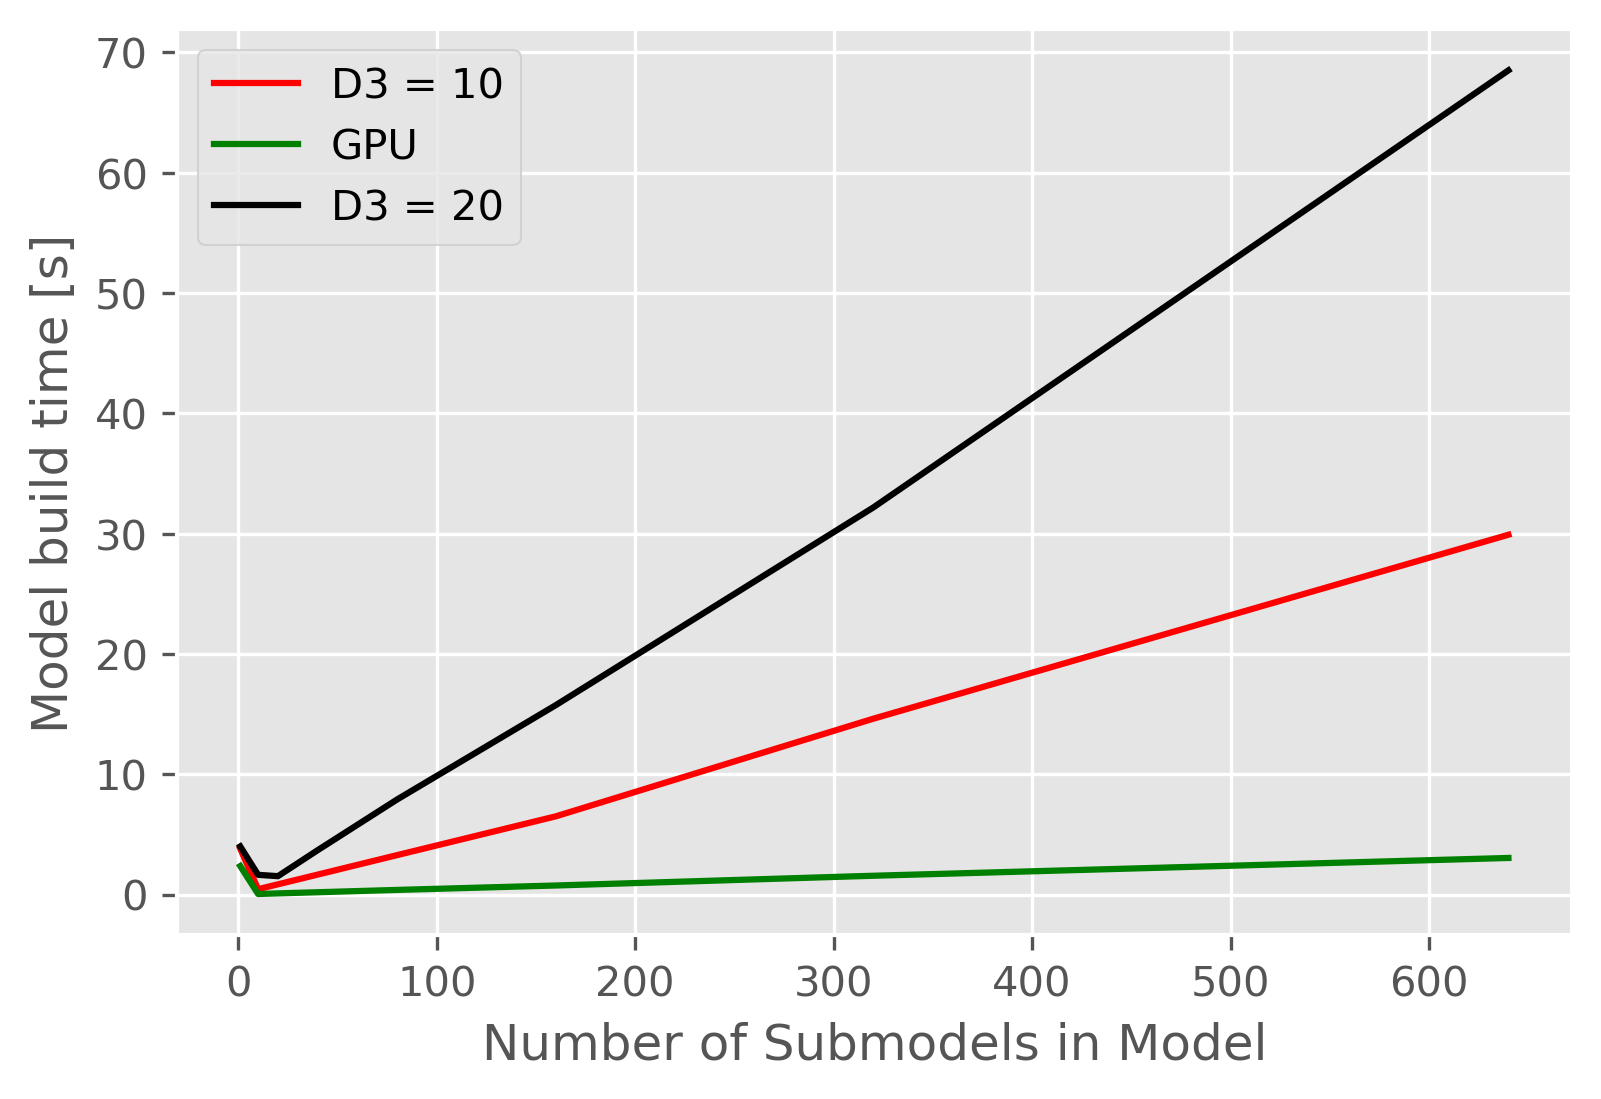

In [34]:
Fig5,ax5 = plt.subplots()
Fig5.set_dpi(300)
ax5.plot(submodel_n,CPUD310.Model_build_times,color="red",label="D3 = 10 (PyMC v3)")
ax5.plot(submodel_n,GPUD310.Model_build_times,color="green",label="GPU (PyMC v4)")
ax5.plot(submodel_n,CPUD320.Model_build_times,color="black",label="D3 = 20 (PyMC v3)")
ax5.set_xlabel("Number of Submodels in Model")
ax5.set_ylabel("Model build time [s]")
ax5.legend()
plt.show()

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>Conclusion and Outlook</H4>
<br>
</div>


---

Probabily the most important insight is that artificially "blowing up" the PyMC models and allow for parallel model fitting can boost sampling times on both CPU and GPU. However, GPU sampling does not seem to perform remarkably better than sampling on the CPU. Still, the findings of Ingram and the PyMC developers <cite data-cite="pymcGPU"></cite> suggests that the difference in sampling performance between CPU and GPU are depending on hardware setups and the model of interest. 



---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>References</H4>
<br>
</div>


---

---

<div style="background-color:rgba(256, 76, 76,0.4)",height="200">
<br>
<H4>To Do</H4>
<br>
</div>


---

Next Steps:

1. Parallelized GLM model
2. Model Evaluation for GLM in pystoms
3. Feature Manager -> handling many features at once
4. Test Model on GPU

5. CPU and GPU breakdown for bigger models in pymc4







---